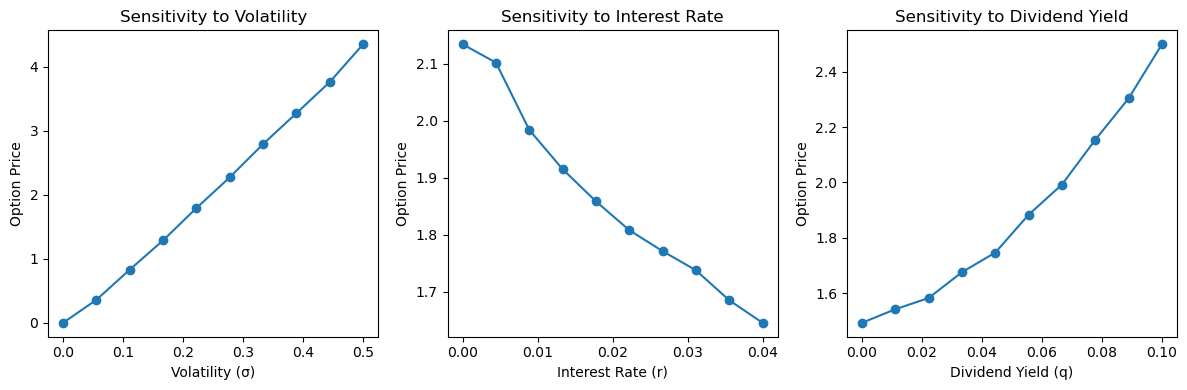

In [5]:
# Fixing the boolean indexing issue and rerunning the sensitivity 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1     # Time to maturity (in years)
r_values = np.linspace(0.0, 0.04, 10)  # Interest rates to test
sigma_values = np.linspace(0.0, 0.5, 10)  # Volatility levels
q_values = np.linspace(0.0, 0.1, 10) # Dividend yields
M = 50  # Time steps
N = 100000  # Number of Monte Carlo paths

def generate_paths(S0, r, sigma, q, T, M, N):
    """Simulate stock price paths using the Geometric Brownian Motion model."""
    dt = T / M
    paths = np.zeros((M + 1, N))
    paths[0] = S0
    for t in range(1, M + 1):
        Z = np.random.standard_normal(N)
        paths[t] = paths[t - 1] * np.exp((r - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths


def compute_lsm_price_fixed(S0, K, T, r, sigma, q, M, N):
    """Price an American put option using the Least Squares Monte Carlo (LSM) method with corrected indexing."""
    dt = T / M
    discount = np.exp(-r * dt)
    stock_paths = generate_paths(S0, r, sigma, q, T, M, N)
    payoffs = np.maximum(K - stock_paths, 0)
    
    # Backward induction
    for t in range(M - 1, 0, -1):
        in_the_money = payoffs[t] > 0
        X = stock_paths[t, in_the_money]
        Y = payoffs[t + 1, in_the_money] * discount
        if len(X) > 0:
            regression = np.polyfit(X, Y, deg=2)
            continuation_value = np.polyval(regression, X)
            exercise = payoffs[t, in_the_money] > continuation_value
            payoffs[t, in_the_money] = np.where(exercise, payoffs[t, in_the_money], payoffs[t + 1, in_the_money] * discount)

    option_price = np.mean(payoffs[1]) * discount
    return option_price

# Re-run sensitivity analysis
results_fixed = {
    "Volatility": [],
    "Interest Rate": [],
    "Dividend Yield": []
}

# Sensitivity to Volatility
for sigma in sigma_values:
    price = compute_lsm_price_fixed(S0, K, T, r=0.05, sigma=sigma, q=0.02, M=M, N=N)
    results_fixed["Volatility"].append(price)

# Sensitivity to Interest Rate
for r in r_values:
    price = compute_lsm_price_fixed(S0, K, T, r=r, sigma=0.2, q=0.02, M=M, N=N)
    results_fixed["Interest Rate"].append(price)

# Sensitivity to Dividend Yield
for q in q_values:
    price = compute_lsm_price_fixed(S0, K, T, r=0.05, sigma=0.2, q=q, M=M, N=N)
    results_fixed["Dividend Yield"].append(price)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(sigma_values, results_fixed["Volatility"], marker='o')
plt.xlabel('Volatility (σ)')
plt.ylabel('Option Price')
plt.title('Sensitivity to Volatility')

plt.subplot(1, 3, 2)
plt.plot(r_values, results_fixed["Interest Rate"], marker='o')
plt.xlabel('Interest Rate (r)')
plt.ylabel('Option Price')
plt.title('Sensitivity to Interest Rate')

plt.subplot(1, 3, 3)
plt.plot(q_values, results_fixed["Dividend Yield"], marker='o')
plt.xlabel('Dividend Yield (q)')
plt.ylabel('Option Price')
plt.title('Sensitivity to Dividend Yield')

plt.tight_layout()
plt.show()
